In [1]:
import pandas as pd
import sqlalchemy
from binance.client import Client
from binance import BinanceSocketManager
import config

In [2]:
client = Client(config.api_key, config.api_secret)

In [3]:
engine = sqlalchemy.create_engine('sqlite:///MATICUSDTstream.db')

In [26]:
df = pd.read_sql('MATICUSDT', engine)

<AxesSubplot:>

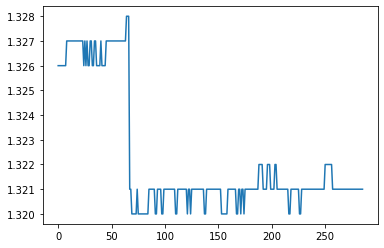

In [27]:
df.Price.plot()

In [28]:
# Algorithm to be used
# Trendfollowing strategy
# If the coin rises by certain %, buy
# Exit when profit is > 0.15% or loss < 0.15%
def trendfollowing(entry, timesteps, qty, open_position=False):
    while True:
        # Requesting live data from db
        df = pd.read_sql('MATICUSDT', engine)
        # Filter time period
        period = df.iloc[-timesteps:]
        # Summing returns for the look back period
        cumret = (period.Price.pct_change() +1).cumprod() - 1

        # Buying position
        if not open_position:
            # Place buy order once cumulative return between time increases by entry %
            if cumret[cumret.last_valid_index()] > entry:
                order = client.create_order(symbol='MATICUSDT', side='BUY', type='MARKET', quantity=qty)
                print(order)
                open_position = True
                break
        
    # Selling position
    if open_position:
        while True:
            # Requesting live data from db
            df = pd.read_sql('MATICUSDT', engine)
            # Timesteps after buying coin
            afterBuy = df.loc[df.Time > pd.to_datetime(order['transactTime'], unit='ms')]

            if len(afterBuy) > 1:
                # Calculate return after buying coin
                afterBuyRet = (afterBuy.Price.pct_change() + 1).cumprod() - 1
                # Cumulative return since buying
                cumretsb = afterBuyRet[afterBuyRet.last_valid_index()]
                if cumretsb > 0.0015 or cumretsb < -0.0015:
                    order = client.create_order(symbol='MATICUSDT', side='SELL', type='MARKET', quantity=qty)
                    print(order)
                    break

In [ ]:
trendfollowing(0.001, 60, )